<a href="https://colab.research.google.com/github/andres4640/Fake-News-Tesis/blob/main/FakeNews_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News

El dataset "COVID Fake News Data.csv" fue extraido de la siguiente dirección: https://zenodo.org/record/4282522#.YJ6FtsCg9Pa

El dataset "fake_new_dataset.xlsx" se obtuvo de la siguiente dirección: https://data.mendeley.com/datasets/zwfdmp5syg/1

Ambos datasets cuentan con columnas que indican si el texto es falso o verdadero. En el caso del primer dataset, la columna "outcome" representa la veracidad del texto y en el segundo dataset, la columna "label". En ambas columnas, el valor "0" representa veracidad y "1" falsedad.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/Tesis/')

In [ ]:
df_one = pd.read_csv("Datasets/COVID Fake News Data.csv")
df_two = pd.read_excel("Datasets/fake_new_dataset.xlsx")

Limpiar los caracteres que no son ASCII:

In [ ]:
from string import printable

df_one.headlines = df_one.headlines.apply(lambda y: ''.join(filter(lambda x: 
            x in printable, y)))

In [ ]:
df_one.outcome.replace({0: 1, 1: 0}).value_counts()

1    9727
0     474
Name: outcome, dtype: int64

In [ ]:
df_one.outcome.replace({0: 1, 1: 0}, inplace=True)
df_one.outcome.value_counts()

1    9727
0     474
Name: outcome, dtype: int64

In [ ]:
df_two.outcome.value_counts()

0    2061
1    1058
Name: outcome, dtype: int64

In [ ]:
df_two.label.replace({0: 1, 1: 0}, inplace=True)
df_two.label.value_counts()

0    2061
1    1058
Name: label, dtype: int64

En el segundo dataset modificamos el nombre de las columnas para poder concatenarlo con el primer dataset

In [ ]:
df_two.rename(columns={"title": "headlines", "label": "outcome"}, inplace=True)

Concatenamos el dataset

In [ ]:
df_one_final = pd.concat([df_one, df_two[["headlines", "outcome"]]], ignore_index=True)

Podemos ver la diferencia de numero de datos entre ambas clases, hay una mayor cantidad de textos clasificados como falsos. Esto representa un desbalance de clases.

In [ ]:
df_one_final.outcome.value_counts()

1    10785
0     2535
Name: outcome, dtype: int64

In [ ]:
df_one_final.isna().sum()

headlines    1
outcome      0
dtype: int64

In [ ]:
df_one_final.dropna(inplace=True)
df_one_final.reset_index(drop=True, inplace=True)

In [ ]:
# Maximo largo de una palabra antes del reproceso
print("Largo oracion Maximo ",df_one_final.headlines.str.len().max())
print("Largo oracion Minimo: ",df_one_final.headlines.str.len().min())
print("Largo oracion Promedio: ",df_one_final.headlines.str.len().mean())

Largo oracion Maximo  673
Largo oracion Minimo:  6
Largo oracion Promedio:  93.10751557924769


## Preprocesamiento de textos

Tamaño del dataset:

In [ ]:
len(df_one_final)

13319

In [ ]:
import re
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
corpus = []
lista_palabras = []
for i in range(len(df_one_final)):
  # Reemplazamos caracteres innecesarios como puntos y comas:
  #texto = re.sub("[^a-zA-Z-á-é-í-ó-ú]", " ", df_one_final["headlines"][i])
  texto = re.sub("[^a-zA-Z]", " ", df_one_final["headlines"][i])

  # Eliminamos espacios extras
  texto = re.sub(r"\s+"," ", texto, flags = re.I)

  # Convertimos el texto a minuscula:
  texto = texto.lower()

  # Dividimos el texto en palabras individuales:
  texto = texto.split()

  # Declaramos el objeto Stemming:
  stemmer = PorterStemmer()

  # Excluimos los Stop Words de los textos:
  lista_stopwords = stopwords.words("english")
  
  # Aplicamos Stemming y omitimos los Stop words:
  texto = [stemmer.stem(palabra) for palabra in texto if not palabra in set(lista_stopwords)]

  lista_palabras.append(texto)
  
  # Unimos las palabras, separados por un espacio:
  texto= " ".join(texto)

  # Añadimos el texto al corpus
  corpus.append(texto)

Creamos una funcioón para conocer el numero de palabras en el corpus:

In [ ]:
def num_palabras(corp):
  palabras_unicas = []
  lista_palabras = []
  for lista in corpus:
    lista_palabras = lista.split()
    for palabra in lista_palabras:
      if palabra not in palabras_unicas:
        palabras_unicas.append(palabra)
  return len(palabras_unicas)

In [ ]:
tamanio_voc = num_palabras(corpus)

## Desarrollo del Modelo

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

### Word2Vec

Descargamos el modelo pre entrenado Word2Vec, el cual se entreno con un corpus de Google News de aproximadamente 3 billones de palabras. Estas se encuentran representado como vectores de 300 dimensiones.

In [ ]:
from tensorflow.keras.utils import get_file
modelo_pre_entrenado = 0
if modelo_pre_entrenado == 1:
  path = get_file('GoogleNews-vectors-negative300.bin.gz', 
  origin='https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz')
  print(path)

In [ ]:
pip install gensim

In [ ]:
#import gensim
#modelo_w2v = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
#w2v_pesos = modelo_w2v.wv.vectors

In [ ]:
#onehot_texto=[one_hot(palabra,tamanio_voc)for palabra in corpus] 
#onehot_texto[:5]

from gensim.models import word2vec
# Modelo word2vec usando la arquitectura CBOW:
model_word2vec = word2vec.Word2Vec(corpus, size=100, window=5, min_count=5, workers=12, sg=0)
w2v_pesos = model_word2vec.wv.vectors
#tamanio_vocab, embedding_size = model_word2vec.shape

#print("Tamaño vocabulario: {} - Dimensiones Embedding: {}".format(vocab_size, embedding_size))

In [ ]:
# Funciones creadas por Guilherme Christmann

def word2token(word):
    try:
        return model_word2vec.wv.vocab[word].index
    except KeyError:
        return 0
def token2word(token):
    return model_word2vec.wv.index2word[token]

### Padding

Se aplica la tecnica de padding para que todas los textos tengan el mismo largo.

In [ ]:
def largo_max(corp):
  max_valor = 0
  for lista in corp:
    largo = len(lista)
    if largo > max_valor:
      max_valor = largo
  return max_valor

In [ ]:
#texto_pad = pad_sequences(onehot_texto, padding = 'pre' ,maxlen = max_largo_oracion)
#print(texto_pad)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
secuencias = tokenizer.texts_to_sequences(corpus)
max_largo_oracion = largo_max(secuencias)
X = pad_sequences(secuencias, maxlen = max_largo_oracion)

In [ ]:
# Numero de dimensiones en los vectores Word2vec
embedding_vector_size = 100
words = list(model_word2vec.wv.vocab)
embedding_matrix = np.zeros((tamanio_voc+1, embedding_vector_size))
for index, word in enumerate(words):    
 embedding_vector = model_word2vec.wv[word]
 if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

Descomentar el codigo cuando se use el modelo Word2vec pre entrenado.

In [ ]:
# unique_words = num_palabras(corpus)
# total_words = unique_words + 1
# skipped_words = 0
# embedding_dim = 300  
# embedding_matrix = np.zeros((total_words, embedding_dim))
# embedding_vector = []
# lista_palabras_na = []
# for word, i in t.word_index.items():
#   try:
#     embedding_vector = modelo_w2v[word]
#     if embedding_vector is not None:
#       embedding_matrix[i] = modelo_w2v[word]
#   except:
#     if word not in lista_palabras_na:
#       lista_palabras_na.append(word)
#     skipped_words = skipped_words+1
#     pass
#   #embedding_matrix[i] = modelo_w2v[word]
# print("Embeddings Matrix shape : ",embedding_matrix.shape)

In [ ]:
#skipped_words

## Modelo LSTM

In [ ]:
model=Sequential()
model.add(Embedding(tamanio_voc+1, embedding_vector_size, input_length=max_largo_oracion, weights = [embedding_matrix]))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile( ='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 100)           943900    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,024,401
Trainable params: 1,024,401
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#X = np.array(texto_pad)

In [ ]:
y = np.array(df_one_final.outcome)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Desbalanceo del dataset

Aplicaremos una combinación de tecnicas de Undersampling y Oversampling para poder tener reducir el desbalance del dataset.

Undersampling -> Reduce el número de la clase mayoritaria al azar a la proporción deseada contra la clase minoritaria. 

OverSampling -> Duplicamos los datos que tienen la clase minoritaria o creamos nuevos ejemplos sinteticos. En el caso de un dataset de texto, no recomendable crear ejemplos.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

over = RandomOverSampler(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
print("Antes de aplicar las tecnicas: ", Counter(y_train))
X_train, y_train = over.fit_resample(X_train, y_train)
print("Despues de aplicar Oversampling: ", Counter(y_train))
X_train, y_train = under.fit_resample(X_train, y_train)
print("Despues de aplicar Undersampling: ", Counter(y_train))

Antes de aplicar las tecnicas:  Counter({1: 8628, 0: 2027})
Despues de aplicar Oversampling:  Counter({1: 8628, 0: 3451})
Despues de aplicar Undersampling:  Counter({1: 6902, 0: 3451})


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
model.fit(X_train,y_train,validation_data=(X_train,y_train),epochs=10,batch_size=64)

Epoch 1/10
162/162 [==============================] - 21s 119ms/step - loss: 0.4801 - accuracy: 0.7674 - val_loss: 0.1836 - val_accuracy: 0.9328
Epoch 2/10
162/162 [==============================] - 19s 115ms/step - loss: 0.1830 - accuracy: 0.9310 - val_loss: 0.1152 - val_accuracy: 0.9587
Epoch 3/10
162/162 [==============================] - 19s 116ms/step - loss: 0.1143 - accuracy: 0.9571 - val_loss: 0.0777 - val_accuracy: 0.9736
Epoch 4/10
162/162 [==============================] - 19s 118ms/step - loss: 0.0874 - accuracy: 0.9705 - val_loss: 0.0643 - val_accuracy: 0.9781
Epoch 5/10
162/162 [==============================] - 19s 119ms/step - loss: 0.0673 - accuracy: 0.9778 - val_loss: 0.0508 - val_accuracy: 0.9816
Epoch 6/10
162/162 [==============================] - 19s 116ms/step - loss: 0.0541 - accuracy: 0.9816 - val_loss: 0.0449 - val_accuracy: 0.9855
Epoch 7/10
162/162 [==============================] - 19s 118ms/step - loss: 0.0469 - accuracy: 0.9858 - val_loss: 0.0368 - val_ac

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

array([[0.99998116],
       [0.9999986 ],
       [0.9996464 ],
       ...,
       [0.9999142 ],
       [0.0317044 ],
       [0.9506495 ]], dtype=float32)

In [ ]:
y_pred_final = []
y_pred_lista = []
for x in y_pred:
  for y in x:
    y_pred_lista.append(y)
    if y >= 0.5:
      y_pred_final.append(1)
    else:
      y_pred_final.append(0)

In [ ]:
y_pred_final = np.array(y_pred_final)
y_pred_lista = np.array(y_pred_lista)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_final)

array([[ 397,  111],
       [ 149, 2007]])

Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def evaluar_modelo(y_pred):
    plt.figure(figsize=(10,5))
    matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         matrix.flatten()/np.sum(matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    
    print("\nAccuracy: ", accuracy)

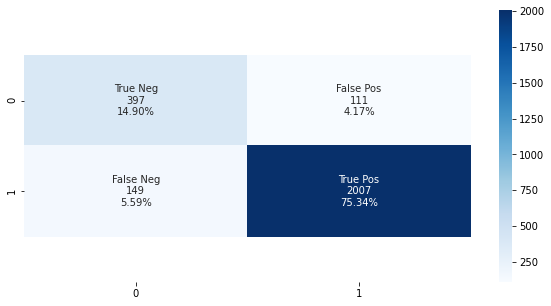


Accuracy:  0.9024024024024024


In [ ]:
evaluar_modelo(y_pred_final)

Recall:

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred_final, average='macro')


0.8561933005127607

ROC Curve:

In [ ]:
y_pred_lista

array([0.99998116, 0.9999986 , 0.9996464 , ..., 0.9999142 , 0.0317044 ,
       0.9506495 ], dtype=float32)

In [ ]:
# y_pred
from sklearn.metrics import roc_curve, roc_auc_score
r_probs = [0 for _ in range(len(y_test))]
redes_probs = y_pred_lista
redes_probs = redes_probs#[:, 1]

r_auc = roc_auc_score(y_test, r_probs)
redes_auc = roc_auc_score(y_test, redes_probs)

print('Predicción aleatoria: AUROC = %.3f' % (r_auc))
print('Modelo Red Neuronal: AUROC = %.3f' % (redes_auc))

Predicción aleatoria: AUROC = 0.500
Modelo Red Neuronal: AUROC = 0.941


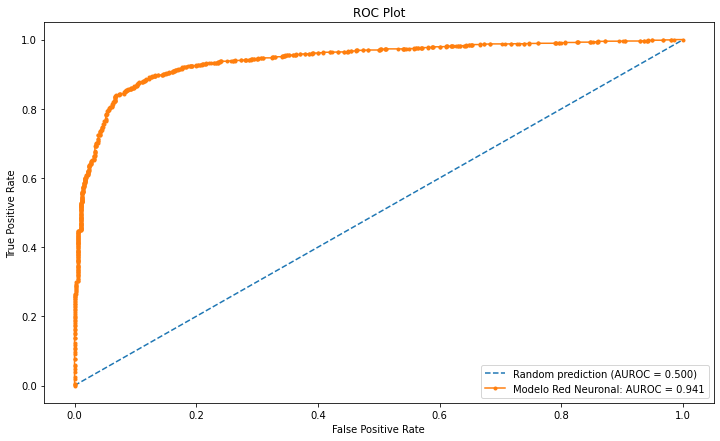

In [ ]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, redes_probs)
plt.figure(figsize=(12,7))
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Modelo Red Neuronal: AUROC = %.3f' % redes_auc)
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()